TODOs

* check whether performance is better with amplitude or intensity as model output
* make the model robust to arbitrary scaling/incorrect normalization of the diffracted intensity
* check consistency of tf's fft implementation with others
* look at perceptual loss like FeatureLoss based on the gram matrix. https://www.reddit.com/r/deeplearning/comments/t8okw7/can_a_cnn_be_used_as_an_autoencoder_for_upscaling/
* Possibly styleGAN, neural style transfer, VGG features, VAE-GAN, fft based loss, gradient loss, or vq-vae. look up those sorts of architectures. https://www.tensorflow.org/tutorials/generative/style_transfer#define_content_and_style_representations
* probe-based support


* Use perceptual loss for reconstruction. Need to set the weights. Read Perceptual Losses for Real-Time Style Transfer
and Super-Resolution
* Reflection invariance: do augmentation to reflect this.
* consistency check on magnitude constraint
* Fully Convolutional Networks for Semantic Segmentation, explore and discuss. Make a slide explaining the idea.
* MC Dropout https://arxiv.org/pdf/1511.02680.pdf
* https://arxiv.org/pdf/1511.02680.pdf

In [1]:
import tf_helper as hh
import fourier as f

2022-10-10 16:32:48.006699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 16:32:48.094230: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-10 16:32:48.436122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2022-10-10 16:32:48.436161: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
path = '.'

import sys
sys.path.append(path)
sys.path.append('PtychoNN/TF2/')

In [3]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import Model

#config = tf.ConfigProto() 
#config.gpu_options.allow_growth=True 
#session = tf.Session(config=config)
#K.set_session(session)

In [4]:
!nvidia-smi

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Oct 10 16:32:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 57%   56C    P8    36W / 420W |  19571MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

In [5]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm.notebook import tqdm as tqdm
%matplotlib inline
import matplotlib

import keras_helper

from tensorflow.keras.layers import Layer
from math import pi
from tensorflow.keras import backend as K

# importlib.reload(keras_helper)
# from keras_helper import *
from skimage.transform import resize

In [6]:
matplotlib.rcParams['font.size'] = 12

### Some training parameters

In [7]:
h,w=64,64
nepochs=20
wt_path = 'wts4' #Where to store network weights
batch_size = 32

# if (not os.path.isdir(path+wt_path)):
#     os.mkdir(wt_path)

### Read experimental diffraction data and reconstructed images

In [8]:
data_diffr = np.load(path+'/PtychoNN/data/20191008_39_diff.npz')['arr_0']
data_diffr.shape

(161, 161, 256, 256)

In [9]:
#plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])

  0%|          | 0/161 [00:00<?, ?it/s]

In [10]:
real_space = np.load(path+'/PtychoNN/data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

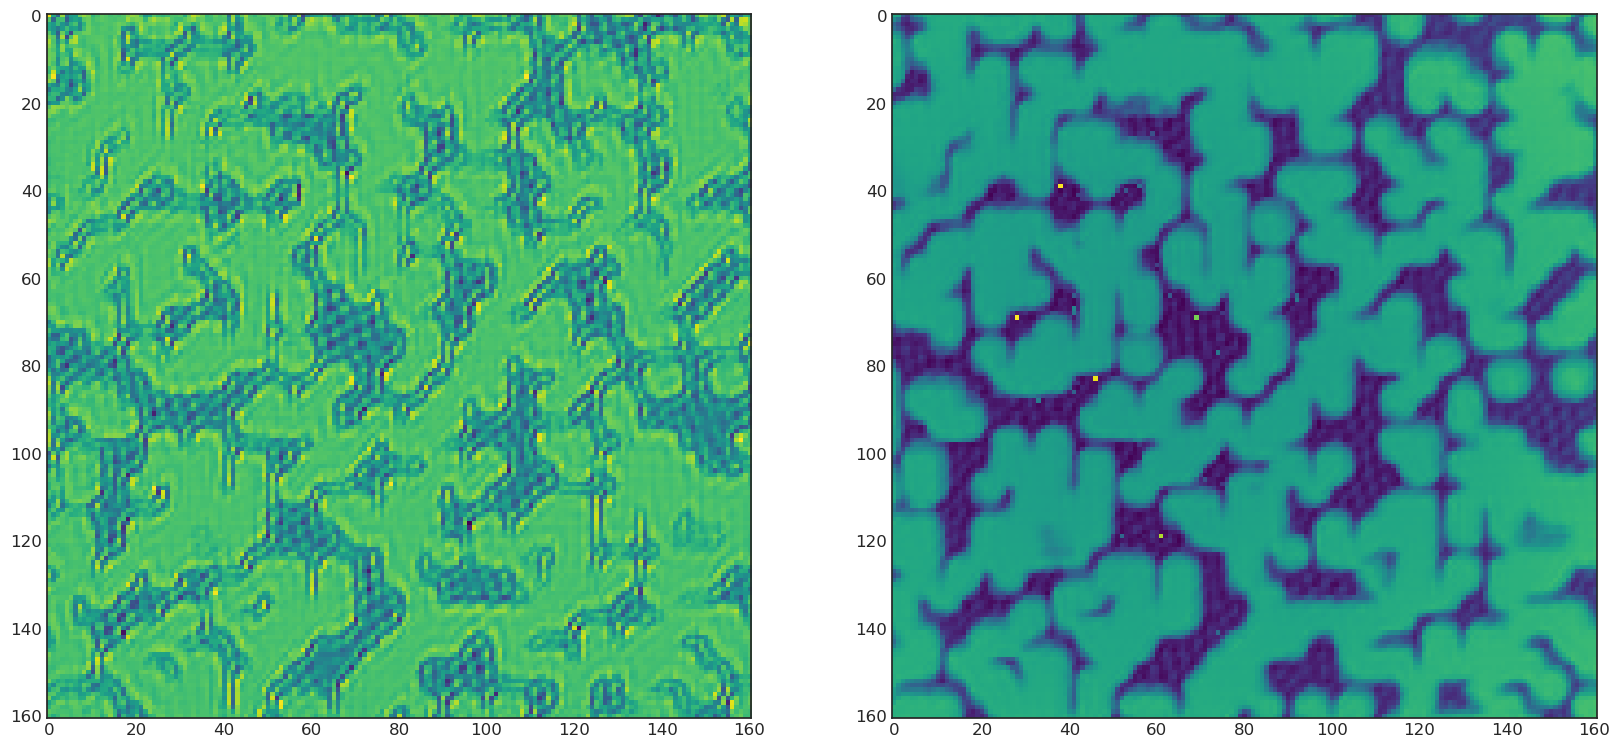

In [11]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32])

### Split data and then shuffle

In [12]:
nlines = 100 #How many lines of data to use for training?
nltest = 60 #How many lines for the test set?
tst_strt = amp.shape[0]-nltest #Where to index from
print(tst_strt)

101


In [13]:
filt = f.lowpass_g(.6, np.ones(h), sym = True)

probe = f.gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 2) + 1e-9
assert (probe[::-1, ::-1] == probe).all() # enforce symmetry

tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])

2022-10-10 16:33:12.152824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 16:33:12.153547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 16:33:12.153733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 16:33:12.153866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

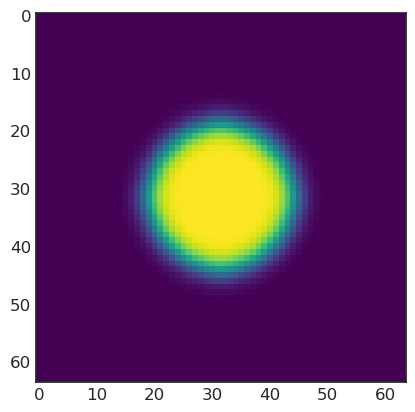

In [14]:
plt.imshow(probe)

In [15]:
N = 64
assert N == h == w

In [16]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

def blowup(img):
    N = img.shape[0]
    assert img.shape[1] == N
    cropped = img[N // 4: -N // 4, N // 4: -N // 4]
    return resize(cropped.copy(), (N, N))

def stack(a1, a2):
    return np.array((a1, a2)).reshape((-1, N, N, 1))

def augment_inversion(X_train, Y_I_train, Y_phi_train):
    return stack(X_train, X_train), stack(Y_I_train, Y_I_train[:, ::-1, ::-1, :]), stack(Y_phi_train, -Y_phi_train)


X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_train = amp[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_train = ph[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

# # Augment using the inversion symmetry
# X_train, Y_I_train, Y_phi_train = augment_inversion(X_train, Y_I_train, Y_phi_train)

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

# # resize to fill the grid better
# X_train = np.array([blowup(arr) for arr in X_train]) * probe[None, ..., None]
# X_test = np.array([blowup(arr) for arr in X_test]) * probe[None, ..., None]

# multiply by the probe illumination
tmp1, tmp2 = Y_I_train, Y_I_test
Y_I_train = Y_I_train *  probe[None, ..., None]
Y_I_test = Y_I_test *  probe[None, ..., None]

(16100, 64, 64, 1) (3600, 64, 64, 1)


In [17]:
def _preprocess(sample):
    return hh.pad_and_diffract(sample, h, w, pad=False)[1]
#     image = tf.cast(tf.image.resize(sample['image'], [N, N]), 
#                     tf.float32) / 255.  # Scale to unit interval.

#     rmod = do_forward(do_resize(N))
#     rmod.compile(loss='mse')
#     orig = tf.identity(image)
#     image = rmod(image)#rmod.predict(image)
#     return image, image, orig
#                  .batch(256)
#                  .map(_preprocess)
#                  .cache()
#                  .prefetch(tf.data.AUTOTUNE)

In [18]:
# X_train = (tf.data.Dataset.from_tensor_slices(Y_I_train)
#            .batch(batch_size)
#            .prefetch(tf.data.AUTOTUNE)
#            .map(_preprocess)
#            .cache())
# X_train = np.vstack(list(iter(X_train)))

# X_test = (tf.data.Dataset.from_tensor_slices(Y_I_test)
#            .batch(batch_size)
#            .prefetch(tf.data.AUTOTUNE)
#            .map(_preprocess)
#            .cache())
# X_test = np.vstack(list(iter(X_test)))

In [18]:
X_train = np.array(hh.pad_and_diffract(Y_I_train, h, w, pad=False)[1])

X_test = np.array(hh.pad_and_diffract(Y_I_test, h, w, pad=False)[1])

FFT consistency check:

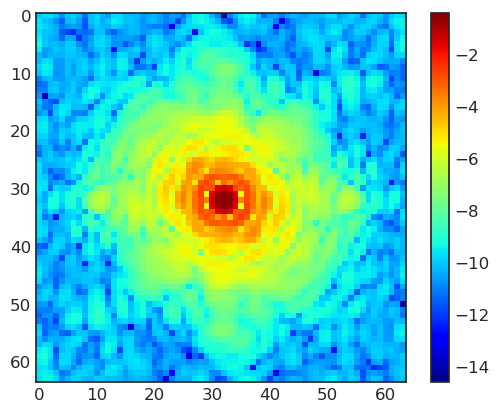

In [19]:
plt.imshow(np.log(f.fftshift(np.absolute(f.fft2(np.array(Y_I_test[0, :, :, 0])))) / h), cmap = 'jet')
plt.colorbar()

In [20]:
def take(ds):
    return next(iter(ds))

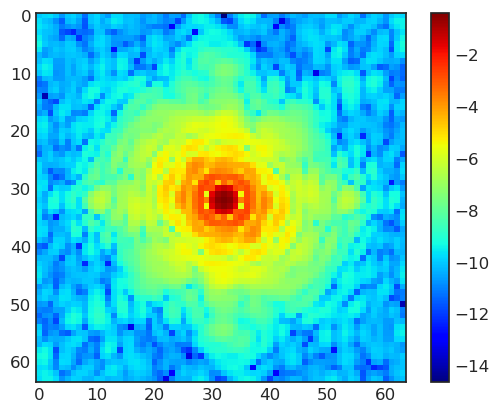

In [21]:
plt.imshow(np.log((X_test)[0, :, :, 0]), cmap = 'jet')
plt.colorbar()

In [22]:
i = 10

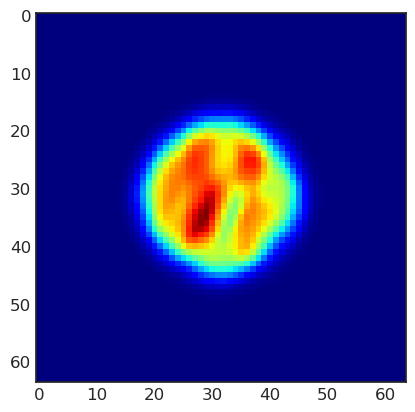

In [23]:
plt.imshow((tmp1 * probe[None, ..., None])[i], cmap = 'jet')

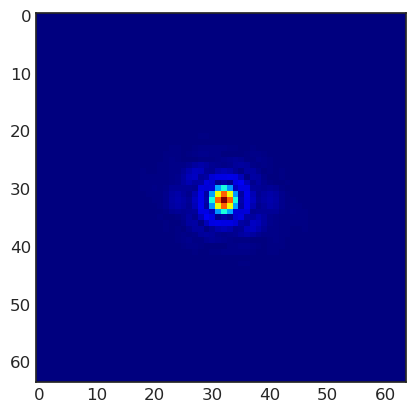

In [24]:
plt.imshow(np.squeeze((X_train)[i]), cmap = 'jet')

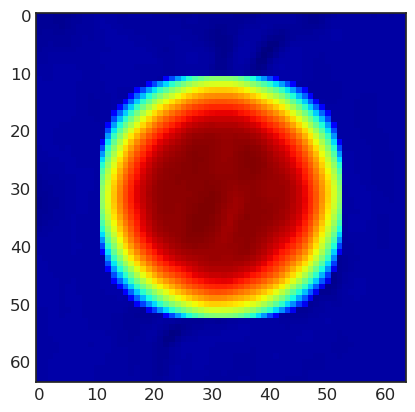

In [25]:
#plt.imshow(np.log(np.squeeze(Y_I_train[i])[16:-16, 16:-16]), cmap = 'jet')
plt.imshow(np.log(np.squeeze(Y_I_train[i])), cmap = 'jet')

### Recover shift between scan points

In [26]:
# import numpy as np
# import scipy.signal

# def cross_image(im1, im2):
#     # get rid of the color channels by performing a grayscale transform
#     # the type cast into 'float' is to avoid overflows
#     im1_gray = im1#np.sum(im1.astype('float'), axis=2)
#     im2_gray = im2#np.sum(im2.astype('float'), axis=2)

#     # get rid of the averages, otherwise the results are not good
#     im1_gray -= np.mean(im1_gray)
#     im2_gray -= np.mean(im2_gray)

#     # calculate the correlation image; note the flipping of onw of the images
#     return scipy.signal.fftconvolve(im1_gray, im2_gray[::-1,::-1], mode='same')

### Full diffraction, no probe envelope:

In [27]:
np.max((X_train))

0.7296028

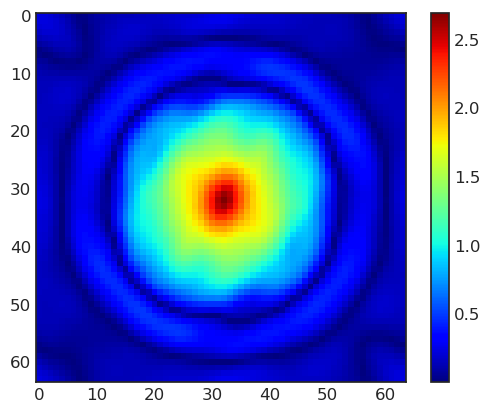

In [28]:
forward = (np.absolute(f.fftshift(f.fft2(f.gf((X_train)[i], 0.).squeeze()))))

plt.imshow(np.log(1 + f.gf(forward, 0)), cmap = 'jet')
plt.colorbar()

## Define the network structure

In [29]:
# %load keras_helper.py
#Keras modules
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, UpSampling2D
from tensorflow.keras import Sequential
from tensorflow.keras import Input
import numpy as np



def Conv_Pool_block(x0,nfilters,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last'):
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = MaxPool2D((p1, p2), padding=padding, data_format=data_format)(x0)
    return x0

def Conv_Up_block(x0,nfilters,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last',
        activation = 'relu'):
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = Conv2D(nfilters, (w1, w2), activation=activation, padding=padding, data_format=data_format)(x0)
    x0 = UpSampling2D((p1, p2), data_format=data_format)(x0)
    return x0

In [30]:
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.layers import Lambda

from importlib import reload
reload(hh)

import math

In [31]:
def get_mask(input, support_threshold):
#     mask = tf.where(input > support_threshold, tf.ones_like(input),
#                     tf.zeros_like(input))
    
    mask = tf.where(tprobe[16:-16, 16:-16, :] > support_threshold, tf.ones_like(input),
                    tf.zeros_like(input))
    return mask

def amplitude_difference(target, pred):
    """
    Calculate object MAE, taking into account that the prediction may be inverted
    """
    abs1 = tf.math.abs(target)
    abs2 = tf.math.abs(pred)
    abs3 = abs2[:, ::-1, ::-1, :]
    mae = tf.keras.losses.MeanAbsoluteError()
    a, b = mae(abs1, abs2), mae(abs1, abs3)
    return tf.minimum(a, b)

In [34]:
tf.keras.backend.clear_session()
np.random.seed(1)

files=glob.glob('%s/*' %wt_path)
for file in files:
    os.remove(file)

input_img = Input(shape=(h, w, 1)) 

x = Conv_Pool_block(input_img,32,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,64,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,128,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')

encoded=x

#Decoding arm for amplitude
x1=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
#x1=Conv_Up_block(x1,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded1 = Conv2D(1, (3, 3), padding='same')(x1)
decoded1 = Lambda(lambda x: sigmoid(x), name='amp')(decoded1)


#Decoding arm for phase
x2=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
#x2=Conv_Up_block(x2,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded2 = Conv2D(1, (3, 3), padding='same')(x2)
decoded2 = Lambda(lambda x: math.pi * tanh(x), name='phi')(decoded2)

obj = Lambda(lambda x: hh.combine_complex(x[0], x[1]),
                     name='obj')([decoded1, decoded2])

# Add real space support
support = Lambda(lambda x: get_mask(x, .01), name='support')(decoded1)
obj = Lambda(lambda x: x[0] * tf.cast(x[1], tf.complex64),
                            name='masked_obj')([obj, support])

# Diffracted amplitude
padded_obj, pred_diff = hh.pad_and_diffract(obj, h, w)


#autoencoder = Model(input_img, pred_diff)
autoencoder = Model([input_img], [pred_diff, padded_obj])


# Make an auxiliary model that exposes the real space object reconstruction
# obj_layer_out = autoencoder.get_layer('obj').output
# aux_model = tf.keras.Model(inputs=autoencoder.inputs,
#                            outputs=autoencoder.outputs + [obj_layer_out])

# The second output exposes the real space object reconstruction but does not contribue to the training loss,
# but it's used to calculate reconstruction errors for validation
autoencoder.compile(optimizer='adam', loss=['mean_absolute_error', amplitude_difference],
                    loss_weights = [1., 0.]
#                     {autoencoder.outputs[0].name.split('/')[0]: 'mean_absolute_error'}
                   )

print (autoencoder.summary())
#plot_model(autoencoder, to_file='paper_data/str_model.png')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

In [35]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# history=autoencoder.fit(X_train, X_train, shuffle=True, batch_size=batch_size, verbose=1, 
#                            epochs=nepochs, validation_split = 0.05, callbacks=[reduce_lr, earlystop])

history=autoencoder.fit([X_train], [X_train, Y_I_train], shuffle=True, batch_size=batch_size, verbose=1, 
                           epochs=3, validation_split = 0.05, callbacks=[reduce_lr, earlystop])

a, b = autoencoder.predict([X_test])

Epoch 1/3
232/478 [=============>................] - ETA: 2s - loss: nan - lambda_2_loss: nan - padded_obj_loss: nan

KeyboardInterrupt: 

In [28]:
# a, b = aux_model.predict(X_train)

In [25]:
def cropshow(arr, *args, **kwargs):
    arr = arr[16:-16, 16:-16]
    plt.imshow(arr, *args, **kwargs)

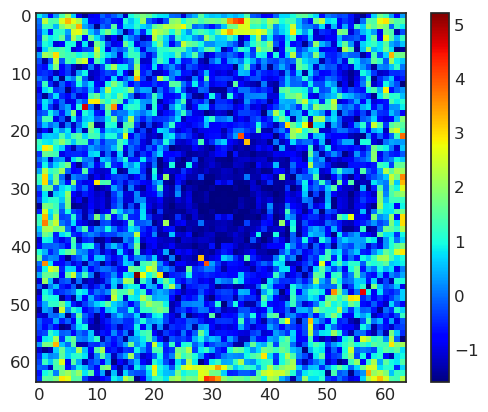

In [26]:
plt.imshow(np.log(.2 + np.abs((a[i] - X_test[i]) / (X_test[i] + 1e-9))), cmap ='jet')
plt.colorbar()

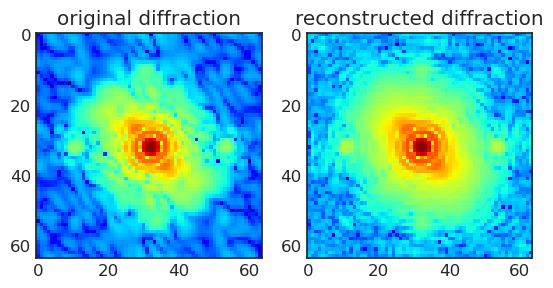

In [27]:
i = 613
aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('original diffraction')
plt.imshow(.1 + np.log(X_test[i]), cmap = 'jet')
#plt.colorbar()

plt.subplot(aa, bb, 2)
plt.title('reconstructed diffraction')
plt.imshow(.1 + np.log(a[i]), cmap = 'jet')
#plt.colorbar()

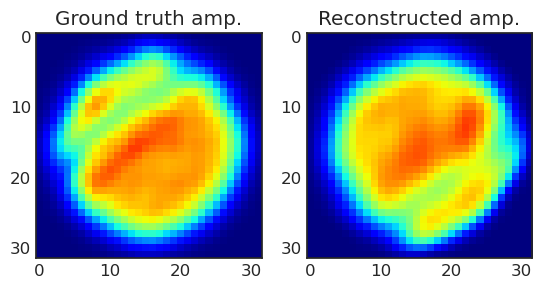

In [36]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
# vmax = tmp2[i].max() * norm
vmin = 0
vmax = 1

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmin = vmin, vmax = vmax)
# plt.colorbar()

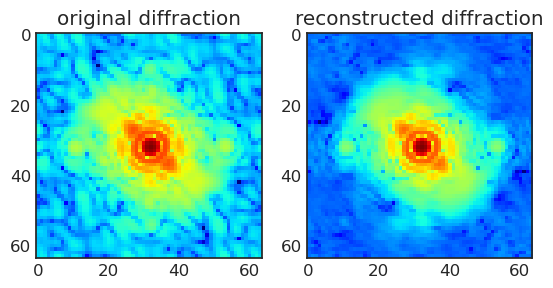

In [33]:
i = 609
aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('original diffraction')
plt.imshow(.1 + np.log(X_test[i]), cmap = 'jet')
#plt.colorbar()

plt.subplot(aa, bb, 2)
plt.title('reconstructed diffraction')
plt.imshow(.1 + np.log(a[i]), cmap = 'jet')
#plt.colorbar()

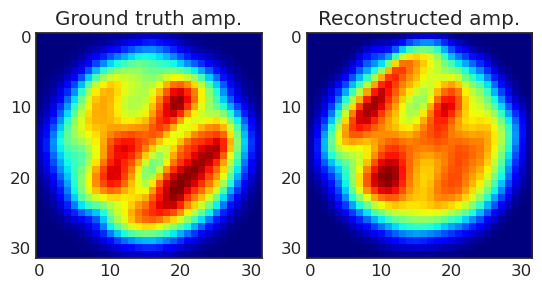

In [37]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
vmax = tmp2[i].max() * norm

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

In [38]:
amplitude_difference(Y_I_test[i:i + 1], (np.absolute(b)[i:i + 1]))

tf.Tensor(0.014161492, shape=(), dtype=float32) tf.Tensor(0.012130551, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.012130551>

In [53]:
y_true = [[1.]]
y_pred = [[1.j]]
# Using 'auto'/'sum_over_batch_size' reduction type.
mae = tf.keras.losses.MeanAbsoluteError()
mae(y_true, y_pred).numpy()

1.4142135623730951

In [ ]:
tf.keras.losses.

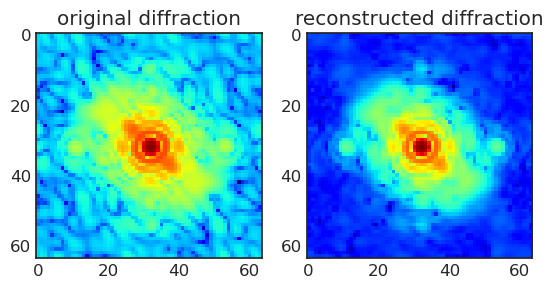

In [38]:
i = 609
aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('original diffraction')
plt.imshow(.1 + np.log(X_test[i]), cmap = 'jet')
#plt.colorbar()

plt.subplot(aa, bb, 2)
plt.title('reconstructed diffraction')
plt.imshow(.1 + np.log(a[i]), cmap = 'jet')
#plt.colorbar()

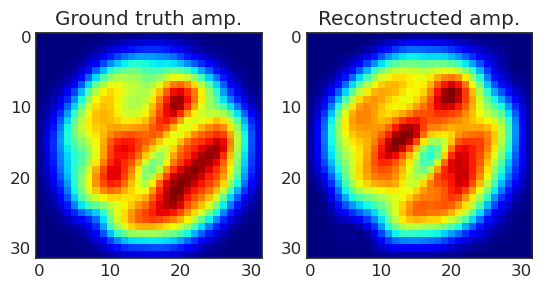

In [39]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
vmax = tmp2[i].max() * norm

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

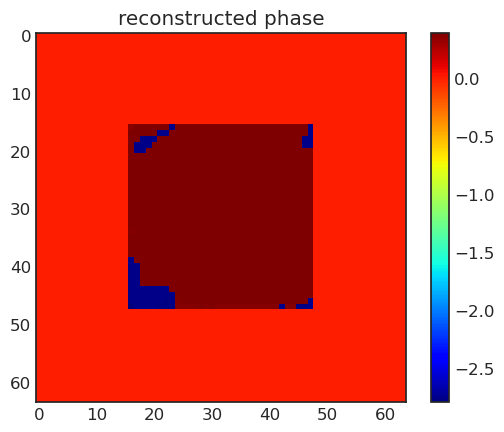

In [44]:
plt.title('reconstructed phase')
plt.imshow((np.angle(b))[i], cmap = 'jet')
plt.colorbar()

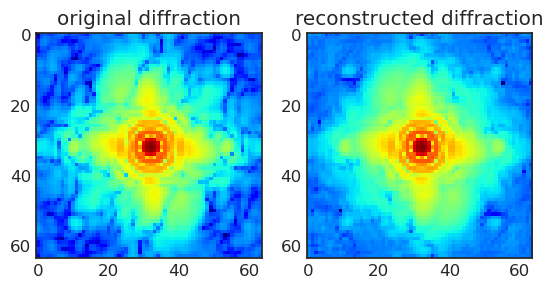

In [224]:
i = 620
aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('original diffraction')
plt.imshow(.1 + np.log(X_test[i]), cmap = 'jet')
#plt.colorbar()

plt.subplot(aa, bb, 2)
plt.title('reconstructed diffraction')
plt.imshow(.1 + np.log(a[i]), cmap = 'jet')
#plt.colorbar()

In [36]:
def amplitude_difference(target, pred):
    abs1 = tf.math.abs(target)
    abs2 = tf.math.abs(pred)
    abs3 = abs2[:, ::-1, ::-1, :]
    mae = tf.keras.losses.MeanAbsoluteError()
    a, b = mae(abs1, abs2), mae(abs1, abs3)
    print(a, b)
    #return a
    return tf.minimum(a, b)

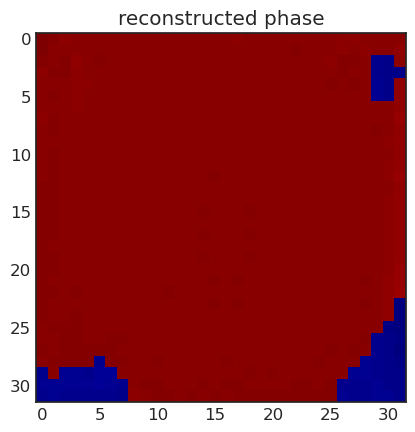

In [208]:
plt.title('reconstructed phase')
plt.imshow((np.angle(b))[i], cmap = 'jet')

In [134]:
# !ln ../../xrd_clustering/notebooks/visualization.py

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [167]:
import visualization as vis
reload(vis)

<module 'visualization' from '/home/ollie/mnt/sys/Documents/scratch/PtychoNN/TF2/visualization.py'>

ground truth


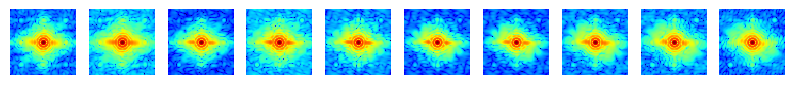

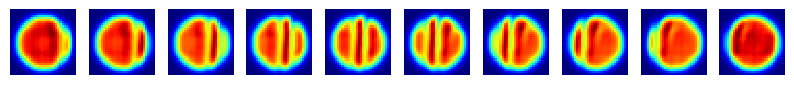

reconstruction


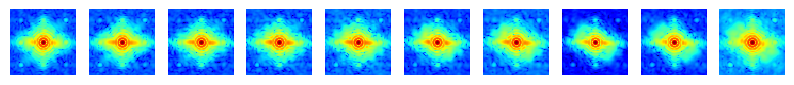

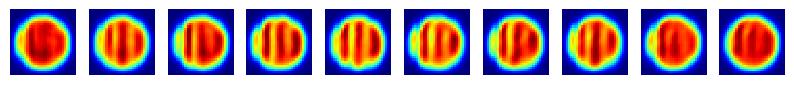

In [180]:
i = 800
print('ground truth')
vis.display_imgs(np.log(X_test[i:i + 10]))
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16][i:i + 10])


print('reconstruction')
vis.display_imgs(np.log(np.absolute(a))[i:i + 10])
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16])[i:i + 10])

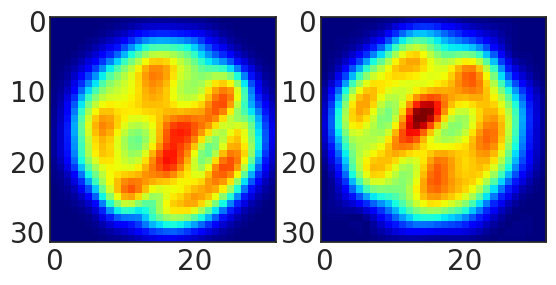

In [110]:
off = 1
i = 607

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.imshow((Y_I_test[i, 16:-16, 16:-16]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.imshow((np.absolute(b))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

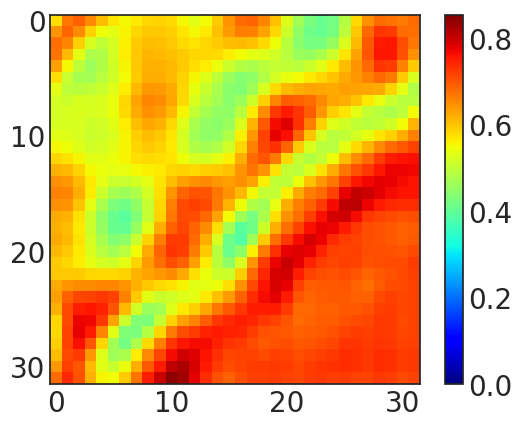

In [98]:
cropshow((tmp2[i] * norm), cmap = 'jet', vmin = 0, vmax = vmax)# tmp2.min(), vmax = tmp2.max())
plt.colorbar()

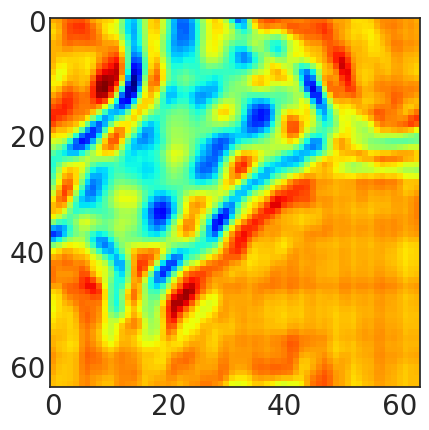

In [70]:
plt.imshow(np.log(off + tmp2[i + 1]), cmap = 'jet')

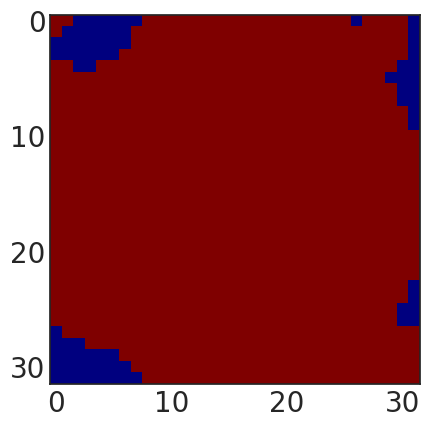

In [61]:
plt.imshow((np.angle(b))[i], cmap = 'jet')

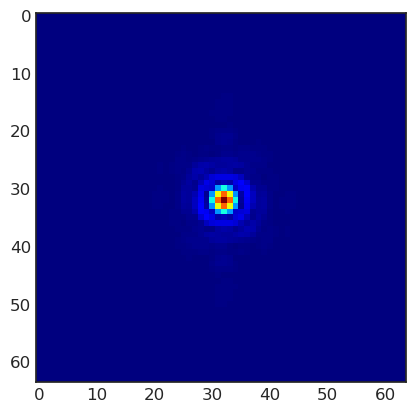

In [153]:
plt.imshow(np.squeeze(X_train[1000]), cmap = 'jet')

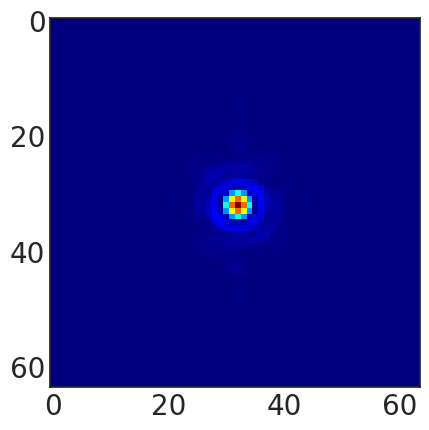

In [78]:
plt.imshow(np.squeeze(X_train[1000]), cmap = 'jet')

## Training metrics

In [53]:
hist.history.keys()

dict_keys(['loss', 'tf.math.sqrt_loss', 'padded_obj_loss', 'val_loss', 'val_tf.math.sqrt_loss', 'val_padded_obj_loss', 'lr'])

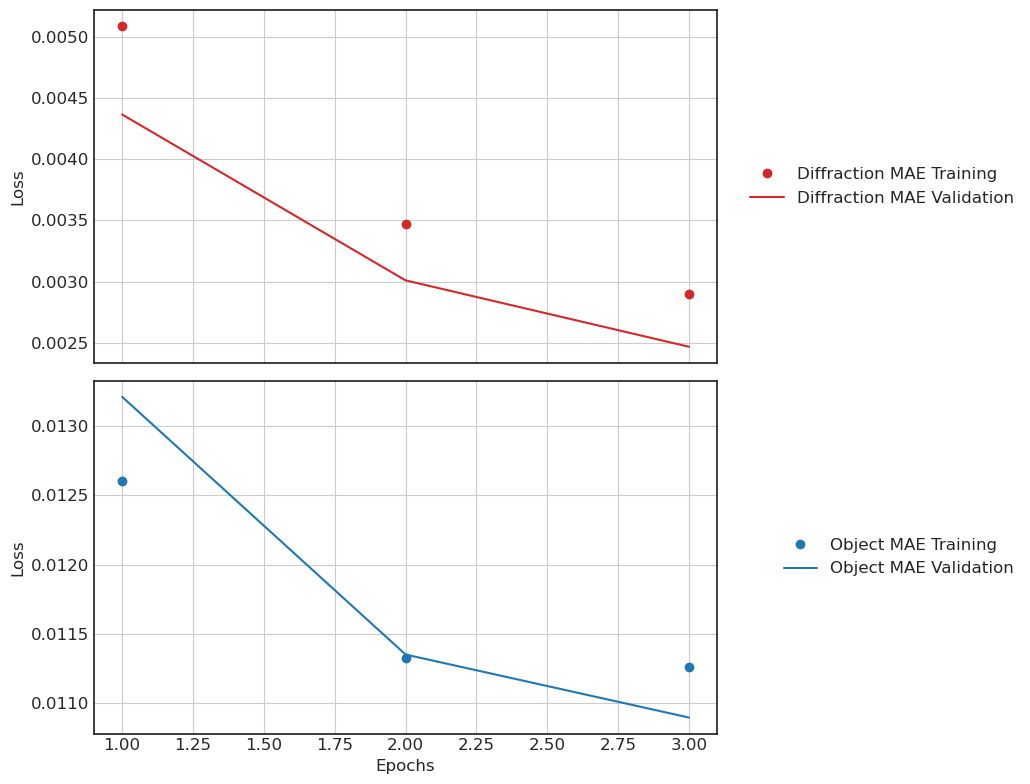

In [29]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 12

f, axarr = plt.subplots(2, sharex=True, figsize=(12, 8))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Diffraction MAE Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Diffraction MAE Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

axarr[1].set(ylabel='Loss')
axarr[1].plot(epochs,hist.history['padded_obj_loss'], 'C0o', label='Object MAE Training')
axarr[1].plot(epochs,hist.history['val_padded_obj_loss'], 'C0-', label='Object MAE Validation')
axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.tight_layout()
#plt.semilogy()
axarr[1].grid()

In [56]:
np.save(path+'str_history', history.history)

In [61]:
# val_losses=hist.history['val_loss']
# min_epoch=np.argmin(val_losses)+1
# print (min_epoch)
# np.save(path+'%s/min_epoch' %(wt_path), min_epoch)
autoencoder.save('{}.h5'.format(wt_path))

In [62]:
!du -sh wts4.h5

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
13M	wts4.h5
